In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

sys.path.append('../../..')

from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W
from batchflow.models.torch.resnet import *
from batchflow.models.torch import ResBlock, SelfAttention
from batchflow.models.torch.layers import ConvBlock
from batchflow.models.metrics import ClassificationMetrics

In [4]:
data = Imagenette160()

In [5]:
train_data = data.train
test_data = data.test

In [6]:
class SAResBlock(nn.Module):
    def __init__(self, **kwargs):
        super(SAResBlock, self).__init__()
        self.layer = ConvBlock({'base': ResBlock, **kwargs}, {'base': SelfAttention, 'layout':}, inputs=kwargs['inputs'])
        
    def forward(self, x):
        return self.layer(x)

In [7]:
config = {
    'inputs': dict(labels={'classes': 10}),
    'device': 'gpu:7',
    'optimizer': ('Adam', {'lr': 0.001}),
   'body/encoder/blocks/base': ResBlock,
    'head': dict(layout='cV', filters=10, kernel_size=1),
    'loss': 'ce',
}

In [8]:
train_pipeline = (train_data.p
                    .init_model('dynamic', ResNet34, 'my_model', config=config)
                    .init_variable('loss', [])
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype=np.float32)
                    .train_model('my_model', B('images'), B('labels'), 
                                   fetches='loss', save_to=V('loss', mode='a'))
                    .run_later(64, n_epochs=1, drop_last=True, shuffle=True, bar=True)           
                 )

In [9]:
train_pipeline.run(bar_desc=W(V('loss')[-1].format('Loss is: {:7.7}')))

Loss is: 1.425016: 100%|██████████| 197/197 [01:02<00:00,  3.15it/s]


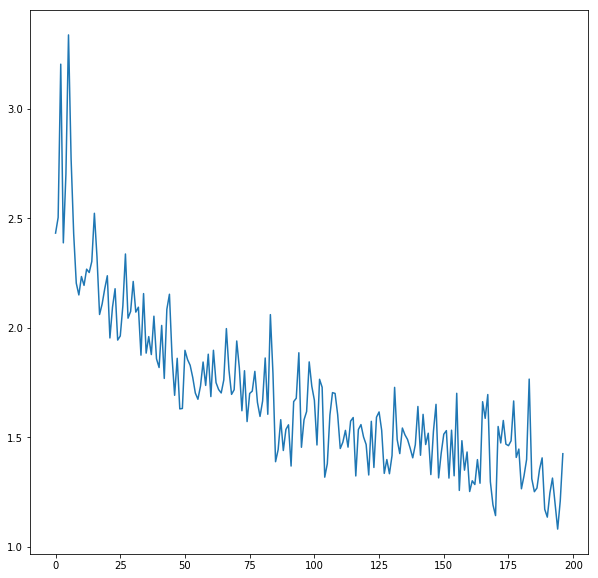

In [10]:
loss = train_pipeline.v('loss')
plt.figure(figsize=(10, 10))
plt.plot(loss)

In [11]:
test_pipeline = (test_data.p
                    .import_model('my_model', train_pipeline)
                    .init_variable('true', [])
                    .update(V('true', mode='a'), B.labels) 
                    .init_variable('predictions', [])
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype=np.float32)
                    .predict_model('my_model', B('images'), fetches='predictions', save_to=V('predictions', mode='a'))
                    .run_later(64, n_epochs=1, drop_last=False, shuffle=True, bar=True)
                  
                )

In [12]:
test_pipeline.run()

100%|██████████| 8/8 [00:01<00:00,  4.40it/s]


In [13]:
predictions = np.concatenate(test_pipeline.v('predictions'))
true = np.concatenate(test_pipeline.v('true'))
predictions = np.argmax(predictions, axis=1)

In [14]:
m = ClassificationMetrics(true, predictions, fmt='labels', num_classes=10)

In [15]:
m.accuracy()

0.5728952772073922